In [46]:
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader,random_split
from torchvision import transforms


RBFN using pytorch

In [8]:
class CustomDataset(Dataset):
    def __init__(self,root_dir,transform=None):
        self.root_dir=root_dir
        self.transform=transform
        self.file_paths=[]
        self.class_names=sorted(os.listdir(root_dir))

        for class_name in self.class_names:
            class_path=os.path.join(self.root_dir,class_name)
            files=[os.path.join(class_path, file) for file in os.listdir(class_path)]
            self.file_paths.extend(files)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self,idx):
        img_path=self.file_paths[idx]
        image=Image.open(img_path)

        if self.transform:
            image=self.transform(image)

        class_name=os.path.basename(os.path.dirname(img_path))
        label_idx=torch.tensor(self.class_names.index(class_name),dtype=torch.long)

        return image,label_idx,class_name

In [9]:
transform=transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])

In [10]:
dataset=CustomDataset(root_dir=r"c:\Users\maha9\OneDrive\Documents\datasets\plants\Bell Pepper\Train",transform=transform)

In [11]:
print("Length of dataset:",len(dataset))
train_size=int(0.8*len(dataset))
test_size=len(dataset)-train_size
train_dataset,test_dataset=random_split(dataset,[train_size,test_size])

Length of dataset: 3901


In [12]:
class RBFLayer(torch.nn.Module):
    def __init__(self,n,input_dim):
        super(RBFLayer,self).__init__()
        self.centers=torch.nn.Parameter(torch.randn(n,input_dim))
        self.sigma=torch.nn.Parameter(torch.ones(n))
    def forward(self,x):
        x=x.view(x.size(0),-1)
        dist=torch.cdist(x,self.centers)
        rbf=torch.exp(-dist.pow(2)/(2*self.sigma.pow(2)))
        return rbf


In [13]:
class RBFNetwork(torch.nn.Module):
    def __init__(self,input_dim,n,od):
        super(RBFNetwork,self).__init__()
        self.rbflayer=RBFLayer(n,input_dim)
        self.linearlayer=torch.nn.Linear(n,od)
    def forward(self,x):
        x=self.rbflayer(x)
        op=self.linearlayer(x)
        return op

In [15]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)

In [20]:
input_dim=3*256*256
od=2
n=50
model=RBFNetwork(input_dim,n,od)
cri=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [24]:
dataiter = iter(train_loader)
for images, _, labels in dataiter:
    print(images.shape, labels)
    print(labels)
    break

torch.Size([32, 3, 256, 256]) ('Bacterial Spot', 'Healthy', 'Healthy', 'Healthy', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Healthy', 'Healthy', 'Bacterial Spot', 'Healthy', 'Healthy', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Healthy', 'Healthy', 'Bacterial Spot', 'Healthy')
('Bacterial Spot', 'Healthy', 'Healthy', 'Healthy', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Healthy', 'Healthy', 'Bacterial Spot', 'Healthy', 'Healthy', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Healthy', 'Healthy', 'Bacterial Spot', 'Healthy')


In [29]:
trainloss=[]
for i in range(5):
    for images,label_idx,labels in train_loader:
        optimizer.zero_grad()
        output=model(images)
        #print(label_idx)
        loss=cri(output,label_idx)
        loss.backward()
        optimizer.step()
    print("epoch ",i+1,loss.item())
    trainloss.append(loss.data)

epoch  1 0.6957269906997681
epoch  2 0.6959197521209717
epoch  3 0.6934783458709717
epoch  4 0.6810778975486755
epoch  5 0.6973689198493958


In [35]:
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=True)

In [36]:
dataiter = iter(test_loader)
for images, _, labels in dataiter:
    print(images.shape, labels)
    print(labels)
    break

torch.Size([32, 3, 256, 256]) ('Healthy', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Bacterial Spot')
('Healthy', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Bacterial Spot', 'Bacterial Spot', 'Healthy', 'Bacterial Spot')


In [30]:
model.eval()

RBFNetwork(
  (rbflayer): RBFLayer()
  (linearlayer): Linear(in_features=50, out_features=2, bias=True)
)

In [43]:
model.eval()
correct = 0
total = 0
testloss=[]

for i in range(5):
    with torch.no_grad():
        for images, labels_idx, labels in test_loader: 
            outputs = model(images)
            loss=cri(outputs,labels_idx)
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            total += labels_idx.size(0)
            correct += (predicted == labels_idx).sum().item()
        testloss.append(loss.data)

accuracy = correct / total
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy: 49.55%


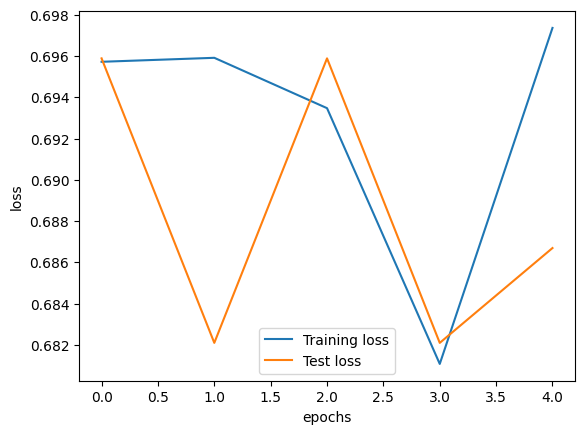

In [44]:
import matplotlib.pyplot as plt
plt.plot(trainloss,label="Training loss")
plt.plot(testloss,label="Test loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [45]:
print(testloss)

[tensor(0.6959), tensor(0.6821), tensor(0.6959), tensor(0.6821), tensor(0.6867)]


RBFN using tensorflow

In [3]:
import tensorflow

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as numpy
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,models
from sklearn.cluster import KMeans


In [9]:
bs=32
ims=(32,32)
data=ImageDataGenerator(rescale=1./255)
train_gen=data.flow_from_directory(r"c:\Users\maha9\OneDrive\Documents\datasets\plants\Apple\Train",
                                   target_size=ims,
                                   batch_size=bs,
                                   class_mode="categorical",
                                   shuffle=True)



Found 7771 images belonging to 4 classes.


In [10]:
test_gen=data.flow_from_directory(r"c:\Users\maha9\OneDrive\Documents\datasets\plants\Apple\Test",
                                   target_size=ims,
                                   batch_size=bs,
                                   class_mode="categorical",
                                   shuffle=False)

Found 196 images belonging to 4 classes.


In [16]:
num_centers=4
kmeansdata=[]
for i in range(len(train_gen)):
    inputs,_=train_gen.next()
    kmeansdata.append(inputs.reshape(inputs.shape[0],-1))

In [17]:
kmeansdata

[array([[0.7411765 , 0.69411767, 0.70980394, ..., 0.5647059 , 0.5137255 ,
         0.5411765 ],
        [0.7411765 , 0.7019608 , 0.8000001 , ..., 0.5686275 , 0.54901963,
         0.6745098 ],
        [0.6       , 0.5803922 , 0.5686275 , ..., 0.3137255 , 0.29411766,
         0.28235295],
        ...,
        [0.63529414, 0.5882353 , 0.6039216 , ..., 0.654902  , 0.59607846,
         0.60784316],
        [0.63529414, 0.6117647 , 0.7137255 , ..., 0.57254905, 0.5372549 ,
         0.6431373 ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 array([[0.42352945, 0.43921572, 0.54509807, ..., 0.5686275 , 0.6117647 ,
         0.72156864],
        [0.52156866, 0.5019608 , 0.4901961 , ..., 0.30588236, 0.2901961 ,
         0.29411766],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.72156864, 0.69803923, 0.8078432 , ..., 0.5647059 , 0.54901963,
         0.69411767

In [18]:
import numpy as np
kmeansdata=np.concatenate(kmeansdata,axis=0)

In [19]:
kmeansdata

array([[0.7411765 , 0.69411767, 0.70980394, ..., 0.5647059 , 0.5137255 ,
        0.5411765 ],
       [0.7411765 , 0.7019608 , 0.8000001 , ..., 0.5686275 , 0.54901963,
        0.6745098 ],
       [0.6       , 0.5803922 , 0.5686275 , ..., 0.3137255 , 0.29411766,
        0.28235295],
       ...,
       [0.41960788, 0.3803922 , 0.38431376, ..., 0.59607846, 0.5764706 ,
        0.5921569 ],
       [0.75294125, 0.70980394, 0.73333335, ..., 0.64705884, 0.6       ,
        0.6156863 ],
       [0.64705884, 0.627451  , 0.6156863 , ..., 0.3647059 , 0.34901962,
        0.3529412 ]], dtype=float32)

In [20]:
kmeans=KMeans(n_clusters=num_centers,random_state=42)
kmeans.fit(kmeansdata)
initial_centers=kmeans.cluster_centers_

c:\Users\maha9\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [21]:
class RBFLayer(layers.Layer):
    def __init__(self, output_dim):
        self.output_dim = output_dim
        super(RBFLayer, self).__init__()

    def build(self, input_shape):
        centers = initial_centers

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[-1]),
                                       initializer=tensorflow.constant_initializer(centers),
                                       trainable=True)
        super(RBFLayer, self).build(input_shape)
    def call(self, x):
        diff = tensorflow.expand_dims(x, axis=1) - self.centers
        norm = tensorflow.norm(diff, axis=-1)
        sigma=tensorflow.math.reduce_std(x)
        return tensorflow.exp(-0.1 * tensorflow.square(norm)/(2*(sigma**2)))

In [30]:
model=models.Sequential([
    layers.Flatten(input_shape=(32, 32, 3)), 
    RBFLayer(4), 
    layers.Dense(4,activation='softmax')  
])

In [31]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
history=model.fit(train_gen,epochs=5,validation_data=test_gen)
test_loss,test_acc=model.evaluate(test_gen)
print("\nTest accuracy: ",test_acc)
print("\nTest loss: ",test_loss)


Epoch 1/5
243/243 [==============================] - 7s 31ms/step - loss: 1.3849 - accuracy: 0.2584 - val_loss: 1.3845 - val_accuracy: 0.2602
Epoch 2/5
243/243 [==============================] - 5s 23ms/step - loss: 1.3849 - accuracy: 0.2563 - val_loss: 1.3845 - val_accuracy: 0.2602
Epoch 3/5
243/243 [==============================] - 6s 24ms/step - loss: 1.3849 - accuracy: 0.2594 - val_loss: 1.3845 - val_accuracy: 0.2602
Epoch 4/5
243/243 [==============================] - 6s 23ms/step - loss: 1.3850 - accuracy: 0.2543 - val_loss: 1.3845 - val_accuracy: 0.2602
Epoch 5/5
7/7 [==============================] - 0s 19ms/step - loss: 1.3845 - accuracy: 0.2602

Test accuracy:  0.2602040767669678

Test loss:  1.3845123052597046
